In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import zipfile
import shutil
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def load_data():
    # CMIP data    
    train = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_train.nc')
    label = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_label.nc')    
   
    train_sst = train['sst'][:, :12].values  # (4645, 12, 24, 72)
    train_t300 = train['t300'][:, :12].values
    train_ua = train['ua'][:, :12].values
    train_va = train['va'][:, :12].values
    train_label = label['nino'][:, 12:36].values

    train_ua = np.nan_to_num(train_ua) # trans nan to 0
    train_va = np.nan_to_num(train_va)
    train_t300 = np.nan_to_num(train_t300)
    train_sst = np.nan_to_num(train_sst)

    # SODA data    
    train2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    label2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    train_sst2 = train2['sst'][:, :12].values  # (100, 12, 24, 72)
    train_t3002 = train2['t300'][:, :12].values
    train_ua2 = train2['ua'][:, :12].values
    train_va2 = train2['va'][:, :12].values
    train_label2 = label2['nino'][:, 12:36].values

    print('Train samples: {}, Valid samples: {}'.format(len(train_label), len(train_label2)))

    dict_train = {
        'sst':train_sst,
        't300':train_t300,
        'ua':train_ua,
        'va': train_va,
        'label': train_label}
    dict_valid = {
        'sst':train_sst2,
        't300':train_t3002,
        'ua':train_ua2,
        'va': train_va2,
        'label': train_label2}
    train_dataset = EarthDataSet(dict_train)
    valid_dataset = EarthDataSet(dict_valid)
    return train_dataset, valid_dataset

In [5]:
set_seed()
train_dataset, valid_dataset = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

Train samples: 4645, Valid samples: 100


In [6]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def train(num_epochs):
    best_score = -99
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):                
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%40 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
        y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        print('Epoch: {}, Valid Score: {}'.format(epoch+1,score))
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(25):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        plt.tight_layout()
        plt.show()

In [201]:
class simpleSpatailTimeNN(nn.Module):
    def __init__(self, embed_dim=64):
        super(simpleSpatailTimeNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=48, kernel_size=(4, 8), padding=(2,4))
        self.bn1 = nn.BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True)
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=(2, 4), padding=(1,2))
        self.bn2 = nn.BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True)
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=(2, 4), padding=(1,2))
        self.bn3 = nn.BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True)
#         self.lstm = nn.LSTM(input_size = 1540, hidden_size = 64, num_layers=2, batch_first=False, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.linear = nn.Linear(6384, 24)

    def forward(self, sst, t300, ua, va):
#         for conv1 in self.conv1:
#             sst = conv1(sst)  # batch * 12 * (24 - 2) * (72 -2)
#         for conv2 in self.conv2:
#             t300 = conv2(t300)
#         for conv3 in self.conv3:
#             ua = conv3(ua)
#         for conv4 in self.conv4:
#             va = conv4(va)
        x = sst # batch * 12 * 24 * 72
        x = self.conv1(x) # batch * 12 * 24 * 72
        x = self.maxpool(x) # batch * 12 * 12 * 36
        x = self.conv2(x) # batch * 12 * 12 * 36
        x = self.maxpool(x) # batch * 12 * 6 * 18
        x = self.conv3(x) # batch * 12 * 6 * 18
        x = self.bn3(x)
        
        x = torch.flatten(x, start_dim=1) # batch * 6384
        
#         sst = torch.flatten(sst, start_dim=2)  # batch * 12 * 1540
#         t300 = torch.flatten(t300, start_dim=2)
#         ua = torch.flatten(ua, start_dim=2)
#         va = torch.flatten(va, start_dim=2)  
        
#         x = torch.cat([sst, t300, ua, va], dim=-1) # batch * 12 * (1540 * 4)
#         x = self.batch_norm(x)
        
#         x, _ = self.lstm(x) # b * 12 * 128
#         x = self.avgpool(x).squeeze(-2) # b * 128
        x = self.dropout(x)
        x = self.linear(x)  # b * 24
        return x

In [202]:
model = simpleSpatailTimeNN()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()   

model = model.to(device)
loss_fn = loss_fn.to(device)

In [203]:
model

simpleSpatailTimeNN(
  (conv1): Conv2d(12, 48, kernel_size=(4, 8), stride=(1, 1), padding=(2, 4))
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(48, 48, kernel_size=(2, 4), stride=(1, 1), padding=(1, 2))
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(48, 48, kernel_size=(2, 4), stride=(1, 1), padding=(1, 2))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=6384, out_features=24, bias=True)
)

In [204]:
# x_month = np.arange(24)
# plt.figure(figsize = (5,5))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.plot(x_month, x_month,color='red')
#     plt.plot(x_month, x_month,color='blue')
# plt.tight_layout()
# plt.show

Step: 0, Train Loss: 1.25629460811615
Step: 40, Train Loss: 0.8249562978744507
Step: 80, Train Loss: 0.8228222727775574
Step: 120, Train Loss: 0.6503662467002869
Epoch: 1, Train loss: 0.7408190961569956
acskill_socre:26.067253441735772, rmse_score:18.542502279827417
Epoch: 1, Valid Score: 7.524751161908355
Model saved successfully


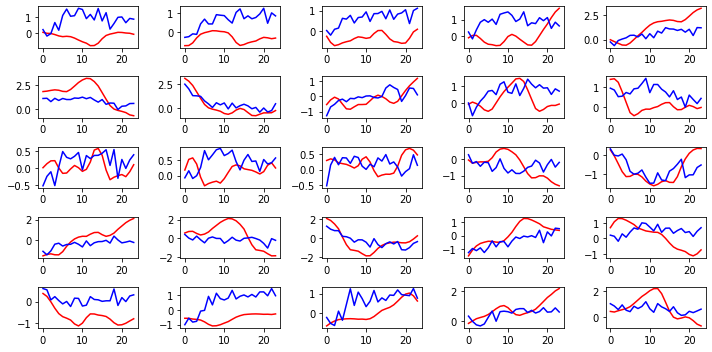

Step: 0, Train Loss: 0.6538002490997314
Step: 40, Train Loss: 0.7364126443862915
Step: 80, Train Loss: 0.8320567011833191
Step: 120, Train Loss: 0.765121340751648
Epoch: 2, Train loss: 0.6372832484441261
acskill_socre:28.701249299273897, rmse_score:17.924301016884932
Epoch: 2, Valid Score: 10.776948282388965
Model saved successfully


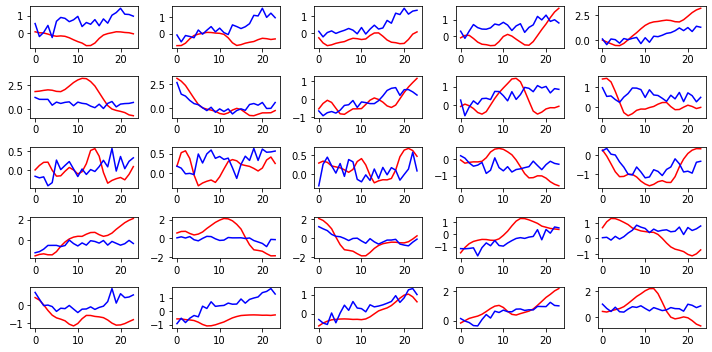

Step: 0, Train Loss: 0.7145707011222839
Step: 40, Train Loss: 0.5868391990661621
Step: 80, Train Loss: 0.7521239519119263
Step: 120, Train Loss: 0.6206252574920654
Epoch: 3, Train loss: 0.6039422460614818
acskill_socre:33.41705236880069, rmse_score:17.335220820121062
Epoch: 3, Valid Score: 16.081831548679627
Model saved successfully


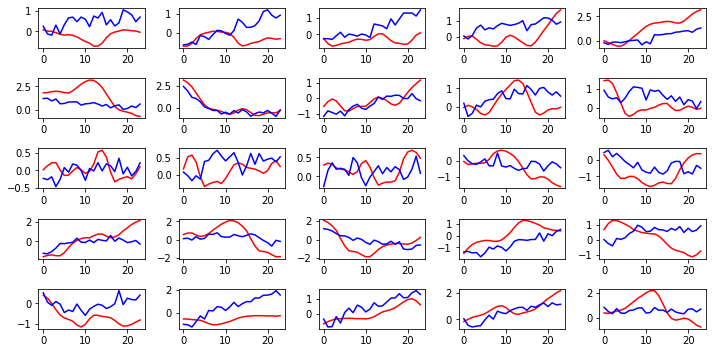

Step: 0, Train Loss: 0.5966187715530396
Step: 40, Train Loss: 0.5243840217590332
Step: 80, Train Loss: 0.5381103754043579
Step: 120, Train Loss: 0.5175026059150696
Epoch: 4, Train loss: 0.5719279763225007
acskill_socre:27.881206520965463, rmse_score:18.252248986947777
Epoch: 4, Valid Score: 9.628957534017687


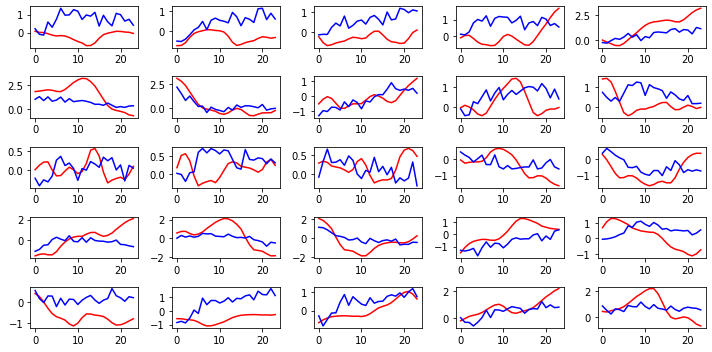

Step: 0, Train Loss: 0.4756559729576111
Step: 40, Train Loss: 0.4415319859981537
Step: 80, Train Loss: 0.5430411100387573
Step: 120, Train Loss: 0.5773043036460876
Epoch: 5, Train loss: 0.5383420639658627
acskill_socre:26.620190139349248, rmse_score:18.51231745718559
Epoch: 5, Valid Score: 8.10787268216366


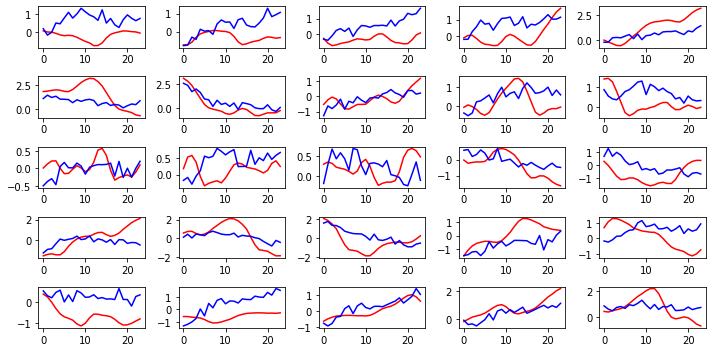

Step: 0, Train Loss: 0.5521323680877686
Step: 40, Train Loss: 0.5472249388694763
Step: 80, Train Loss: 0.4640129804611206
Step: 120, Train Loss: 0.5841922760009766
Epoch: 6, Train loss: 0.5224229595432542
acskill_socre:27.72053534261832, rmse_score:18.301128541478803
Epoch: 6, Valid Score: 9.419406801139516


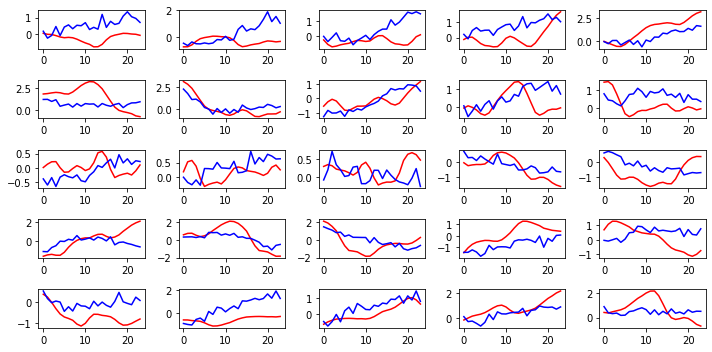

Step: 0, Train Loss: 0.3872777223587036
Step: 40, Train Loss: 0.41885289549827576
Step: 80, Train Loss: 0.7256743311882019
Step: 120, Train Loss: 0.6298102140426636
Epoch: 7, Train loss: 0.4884108739764723
acskill_socre:30.03960082879476, rmse_score:18.44987407888981
Epoch: 7, Valid Score: 11.589726749904951


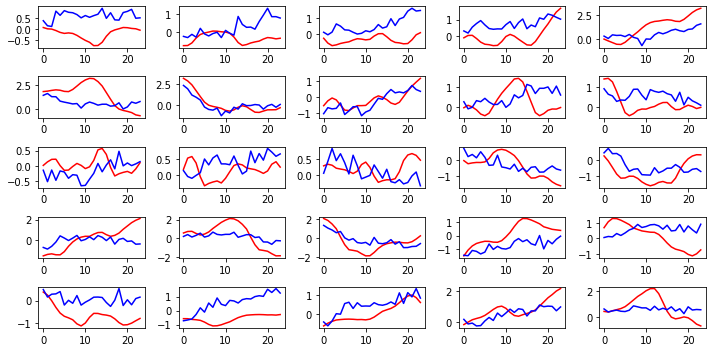

Step: 0, Train Loss: 0.5520457625389099
Step: 40, Train Loss: 0.5576426982879639
Step: 80, Train Loss: 0.5073642730712891
Step: 120, Train Loss: 0.4909093379974365
Epoch: 8, Train loss: 0.4671777844020765
acskill_socre:27.497476710912423, rmse_score:18.257788819037554
Epoch: 8, Valid Score: 9.239687891874869


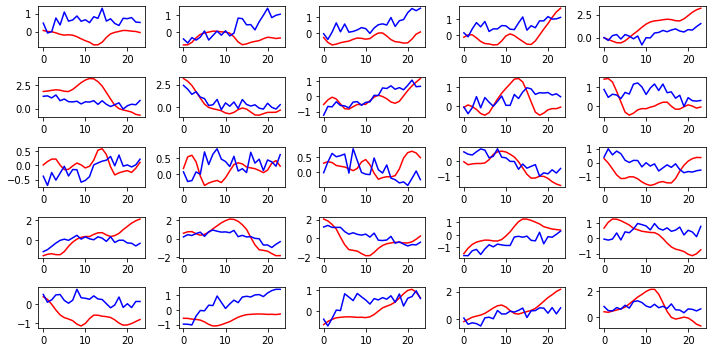

Step: 0, Train Loss: 0.431797593832016
Step: 40, Train Loss: 0.3905894458293915
Step: 80, Train Loss: 0.3863414525985718
Step: 120, Train Loss: 0.4051574170589447
Epoch: 9, Train loss: 0.4376078619532389
acskill_socre:26.699419938261286, rmse_score:18.556647805408563
Epoch: 9, Valid Score: 8.142772132852723


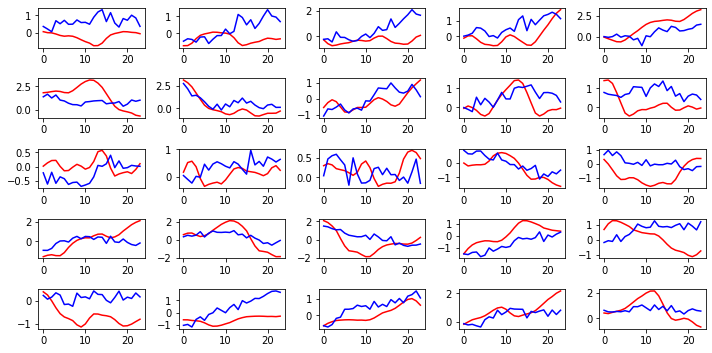

Step: 0, Train Loss: 0.31032106280326843
Step: 40, Train Loss: 0.3463229537010193
Step: 80, Train Loss: 0.2952296733856201
Step: 120, Train Loss: 0.3477996587753296
Epoch: 10, Train loss: 0.40772589296102524
acskill_socre:23.526243598772574, rmse_score:19.265223011560312
Epoch: 10, Valid Score: 4.261020587212261


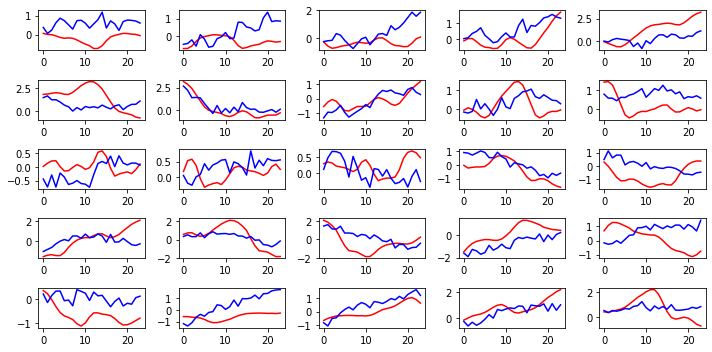

Step: 0, Train Loss: 0.36259233951568604
Step: 40, Train Loss: 0.2966945171356201
Step: 80, Train Loss: 0.3315192461013794
Step: 120, Train Loss: 0.42737433314323425
Epoch: 11, Train loss: 0.3747513799430573
acskill_socre:25.775902953064943, rmse_score:18.479077906829257
Epoch: 11, Valid Score: 7.296825046235686


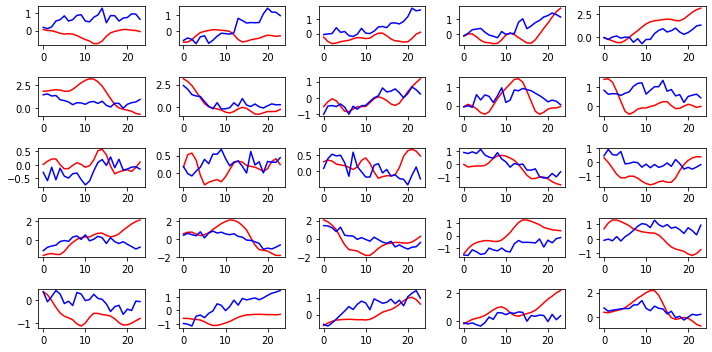

Step: 0, Train Loss: 0.3269118666648865
Step: 40, Train Loss: 0.2830037772655487
Step: 80, Train Loss: 0.37102359533309937
Step: 120, Train Loss: 0.3484220504760742
Epoch: 12, Train loss: 0.3525539063019295
acskill_socre:21.079740785447843, rmse_score:18.984303577651122
Epoch: 12, Valid Score: 2.0954372077967207


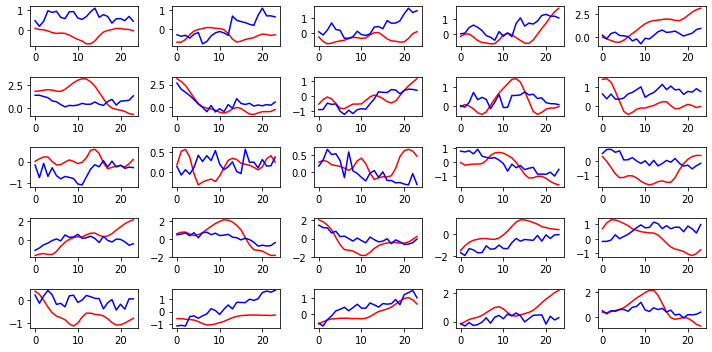

Step: 0, Train Loss: 0.3024645447731018
Step: 40, Train Loss: 0.2704101800918579
Step: 80, Train Loss: 0.30809932947158813
Step: 120, Train Loss: 0.3319126069545746
Epoch: 13, Train loss: 0.32274230600219883
acskill_socre:22.8336398521433, rmse_score:19.106645461857035
Epoch: 13, Valid Score: 3.726994390286265


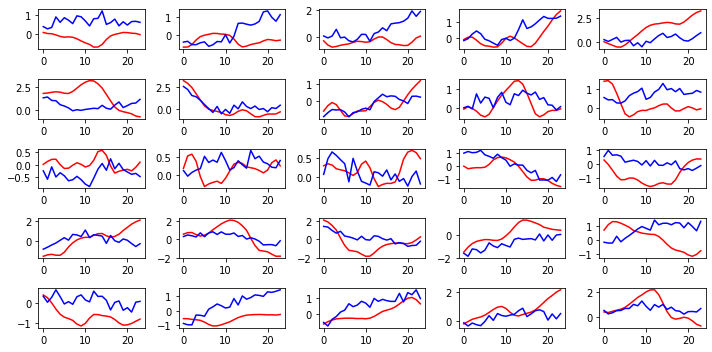

Step: 0, Train Loss: 0.24753829836845398
Step: 40, Train Loss: 0.2871588170528412
Step: 80, Train Loss: 0.2840955853462219
Step: 120, Train Loss: 0.32740265130996704
Epoch: 14, Train loss: 0.299301271160988
acskill_socre:22.05926573313333, rmse_score:19.255695855606472
Epoch: 14, Valid Score: 2.803569877526858


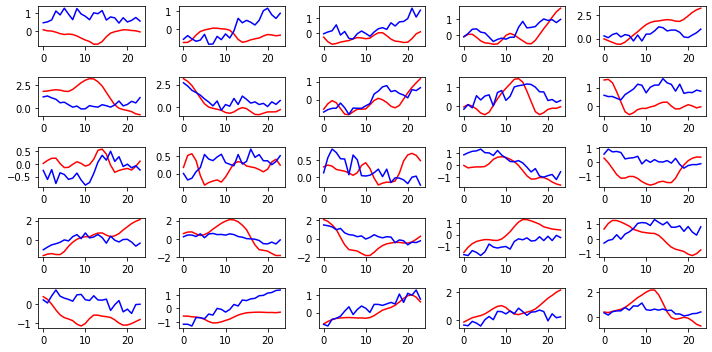

Step: 0, Train Loss: 0.3597034215927124
Step: 40, Train Loss: 0.29757189750671387
Step: 80, Train Loss: 0.29494285583496094
Step: 120, Train Loss: 0.22032706439495087
Epoch: 15, Train loss: 0.2740356735374829
acskill_socre:15.91466968034808, rmse_score:19.165381022460366
Epoch: 15, Valid Score: -3.250711342112286


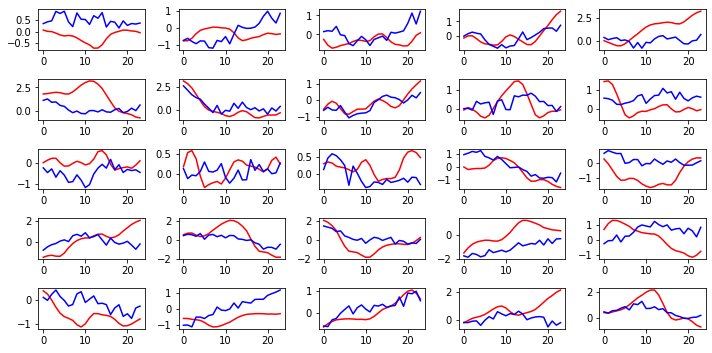

Step: 0, Train Loss: 0.28707194328308105
Step: 40, Train Loss: 0.27010756731033325
Step: 80, Train Loss: 0.2271685004234314
Step: 120, Train Loss: 0.25209343433380127
Epoch: 16, Train loss: 0.25381257619759806
acskill_socre:20.257327851001573, rmse_score:19.65041427852902
Epoch: 16, Valid Score: 0.6069135724725534


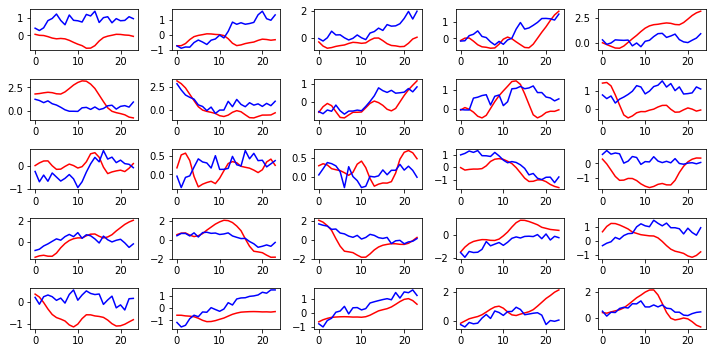

Step: 0, Train Loss: 0.27024349570274353
Step: 40, Train Loss: 0.2046736180782318
Step: 80, Train Loss: 0.21988630294799805
Step: 120, Train Loss: 0.30902034044265747
Epoch: 17, Train loss: 0.23544246417610612
acskill_socre:17.51358479972196, rmse_score:20.264216302412716
Epoch: 17, Valid Score: -2.750631502690755


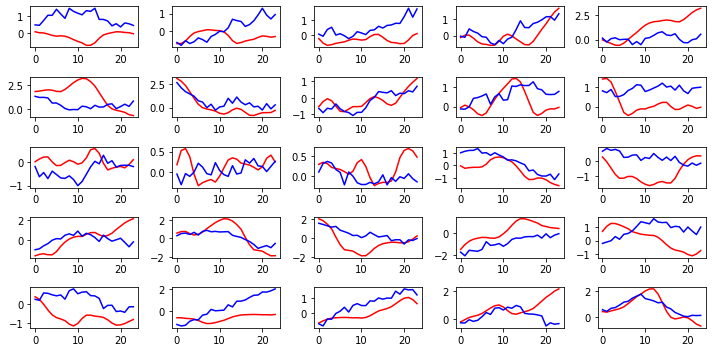

Step: 0, Train Loss: 0.1810768097639084
Step: 40, Train Loss: 0.1992158144712448
Step: 80, Train Loss: 0.21422883868217468
Step: 120, Train Loss: 0.24643675982952118
Epoch: 18, Train loss: 0.21877727535081237
acskill_socre:18.287320984901417, rmse_score:19.83679699206969
Epoch: 18, Valid Score: -1.5494760071682734


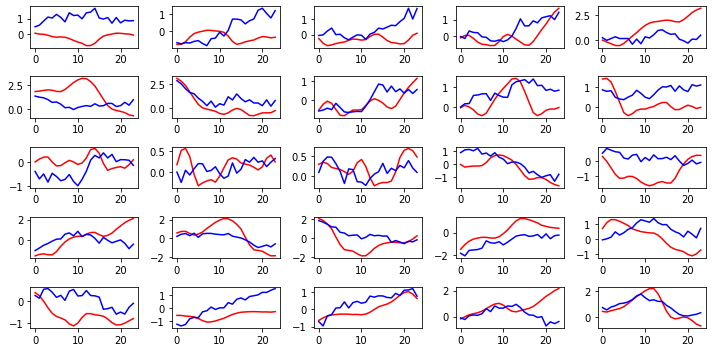

Step: 0, Train Loss: 0.13913021981716156
Step: 40, Train Loss: 0.1974436491727829
Step: 80, Train Loss: 0.20422586798667908
Step: 120, Train Loss: 0.26372233033180237
Epoch: 19, Train loss: 0.20434530273284
acskill_socre:14.529758550134838, rmse_score:20.116388647695352
Epoch: 19, Valid Score: -5.586630097560514


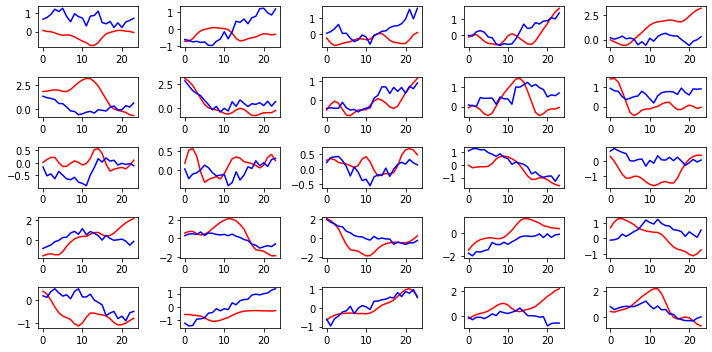

Step: 0, Train Loss: 0.24368272721767426
Step: 40, Train Loss: 0.1625158190727234
Step: 80, Train Loss: 0.19646066427230835
Step: 120, Train Loss: 0.1996050477027893
Epoch: 20, Train loss: 0.1935442013487424
acskill_socre:15.01849584326203, rmse_score:20.193773710960535
Epoch: 20, Valid Score: -5.1752778676985045


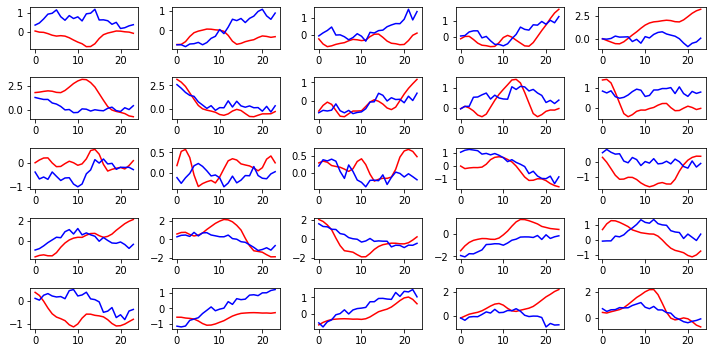

Step: 0, Train Loss: 0.18910670280456543
Step: 40, Train Loss: 0.13758349418640137
Step: 80, Train Loss: 0.18467769026756287
Step: 120, Train Loss: 0.1897038072347641
Epoch: 21, Train loss: 0.1821986323554222
acskill_socre:12.556713882726697, rmse_score:20.518519519438595
Epoch: 21, Valid Score: -7.9618056367118974


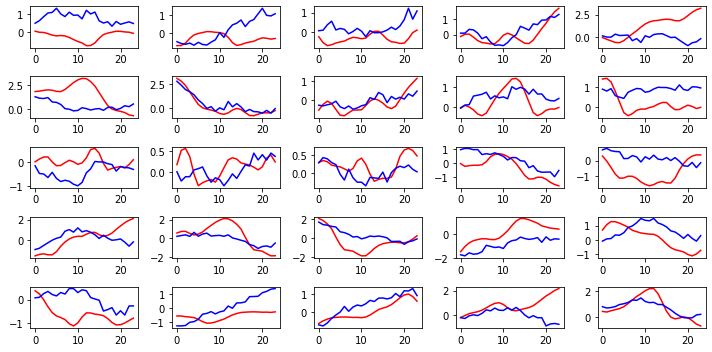

Step: 0, Train Loss: 0.15893886983394623
Step: 40, Train Loss: 0.18679672479629517
Step: 80, Train Loss: 0.14064979553222656
Step: 120, Train Loss: 0.19416314363479614
Epoch: 22, Train loss: 0.17058200236052684
acskill_socre:14.706804329203354, rmse_score:20.287215199130852
Epoch: 22, Valid Score: -5.580410869927498


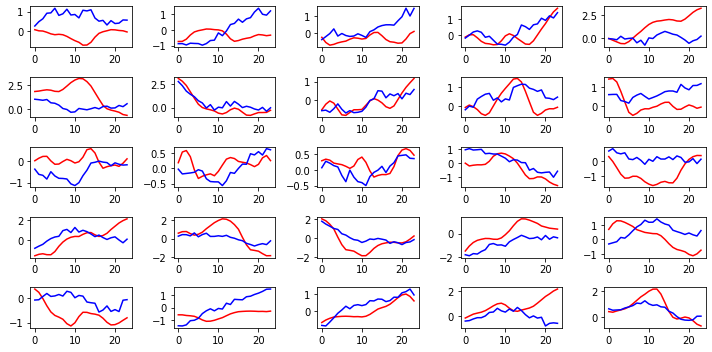

Step: 0, Train Loss: 0.1555456966161728
Step: 40, Train Loss: 0.15312528610229492
Step: 80, Train Loss: 0.20016805827617645
Step: 120, Train Loss: 0.24654965102672577
Epoch: 23, Train loss: 0.16422841784684625
acskill_socre:12.912145180946, rmse_score:20.137018881175614
Epoch: 23, Valid Score: -7.2248737002296135


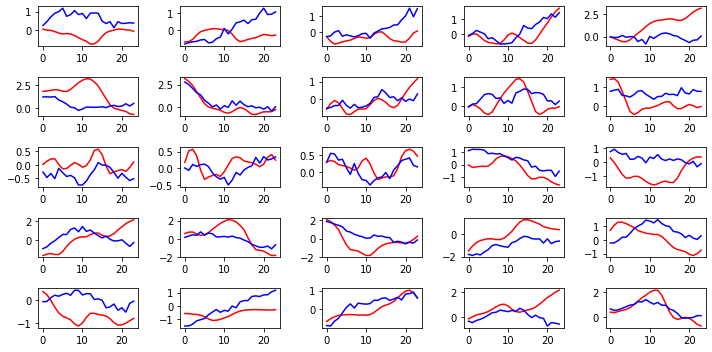

Step: 0, Train Loss: 0.13232645392417908
Step: 40, Train Loss: 0.16210266947746277
Step: 80, Train Loss: 0.15793323516845703
Step: 120, Train Loss: 0.15689019858837128
Epoch: 24, Train loss: 0.1551164902542552
acskill_socre:13.238916126019818, rmse_score:20.556600255872844
Epoch: 24, Valid Score: -7.317684129853026


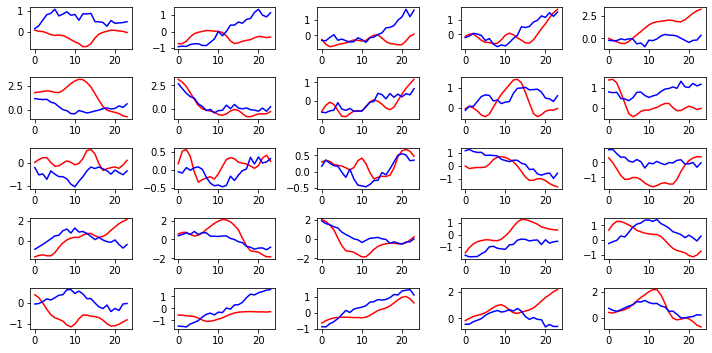

Step: 0, Train Loss: 0.13381950557231903
Step: 40, Train Loss: 0.12165655940771103
Step: 80, Train Loss: 0.14582329988479614
Step: 120, Train Loss: 0.16074544191360474
Epoch: 25, Train loss: 0.14753449718429618
acskill_socre:12.037167473729115, rmse_score:20.594052343234583
Epoch: 25, Valid Score: -8.556884869505469


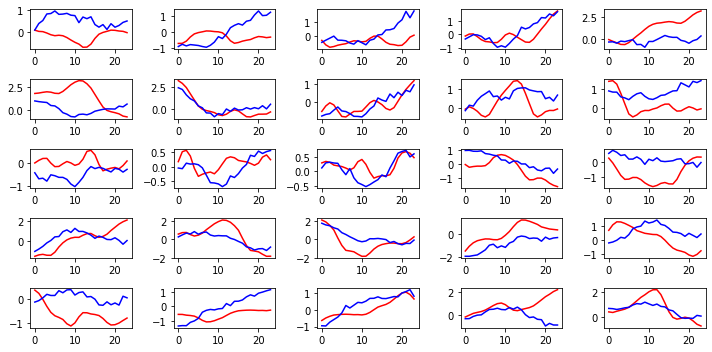

Step: 0, Train Loss: 0.12413972616195679
Step: 40, Train Loss: 0.15510816872119904
Step: 80, Train Loss: 0.13323725759983063
Step: 120, Train Loss: 0.1647985428571701
Epoch: 26, Train loss: 0.1432778135656494
acskill_socre:13.977989680666484, rmse_score:20.699987187445007
Epoch: 26, Valid Score: -6.721997506778523


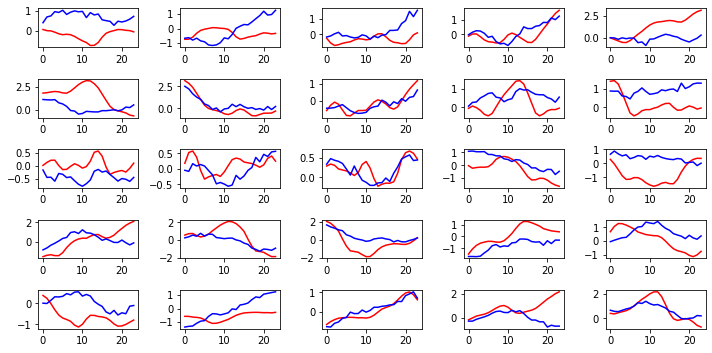

Step: 0, Train Loss: 0.12080667912960052
Step: 40, Train Loss: 0.12700814008712769
Step: 80, Train Loss: 0.14496253430843353
Step: 120, Train Loss: 0.14269044995307922
Epoch: 27, Train loss: 0.13650278430687238
acskill_socre:9.870244882559078, rmse_score:20.788236925072543
Epoch: 27, Valid Score: -10.917992042513465


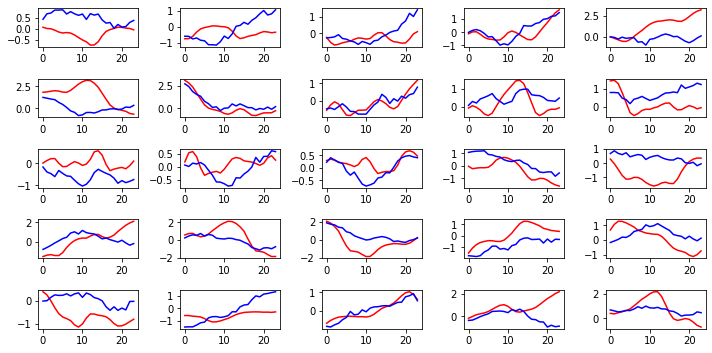

Step: 0, Train Loss: 0.14934159815311432
Step: 40, Train Loss: 0.12310035526752472
Step: 80, Train Loss: 0.10407675802707672
Step: 120, Train Loss: 0.13642853498458862
Epoch: 28, Train loss: 0.13130983939930185
acskill_socre:13.546701731850892, rmse_score:20.449336331064917
Epoch: 28, Valid Score: -6.902634599214025


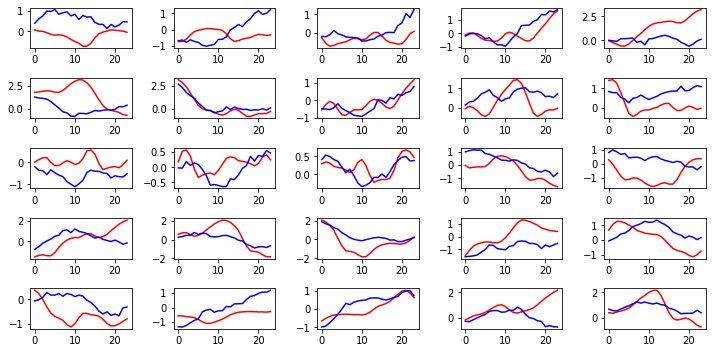

Step: 0, Train Loss: 0.13171470165252686
Step: 40, Train Loss: 0.1224198192358017
Step: 80, Train Loss: 0.13348710536956787
Step: 120, Train Loss: 0.12036257982254028
Epoch: 29, Train loss: 0.12456939303099293
acskill_socre:12.836437402332859, rmse_score:20.514092174944917
Epoch: 29, Valid Score: -7.677654772612058


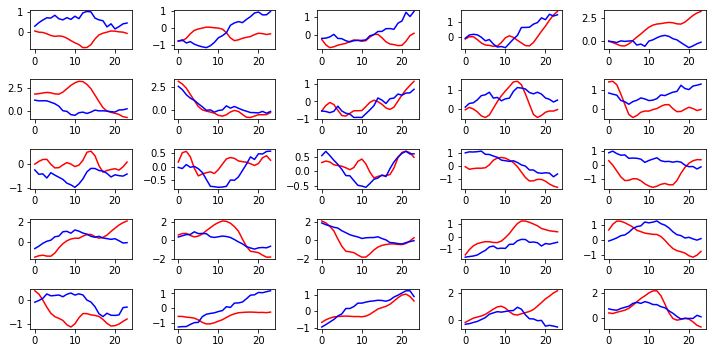

Step: 0, Train Loss: 0.11403059959411621
Step: 40, Train Loss: 0.11771135777235031
Step: 80, Train Loss: 0.12643101811408997
Step: 120, Train Loss: 0.12771844863891602
Epoch: 30, Train loss: 0.12765179783718228
acskill_socre:11.095309451278723, rmse_score:20.98740992089681
Epoch: 30, Valid Score: -9.892100469618086


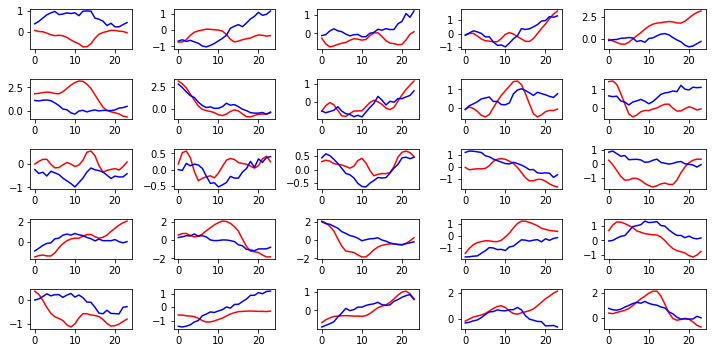

In [205]:
train(num_epochs=30)

In [94]:
model.load_state_dict(torch.load('models/basemodel_epoch_5.pt'))

<All keys matched successfully>

In [7]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [8]:
### 2. predict
test_predicts_dict = {}
for file_name,val in test_feas_dict.items():
    SST = torch.tensor(val[:,:,:,0]).unsqueeze(0).to(device).float()
    T300 = torch.tensor(val[:,:,:,1]).unsqueeze(0).to(device).float()
    Ua = torch.tensor(val[:,:,:,2]).unsqueeze(0).to(device).float()
    Va = torch.tensor(val[:,:,:,3]).unsqueeze(0).to(device).float()
    test_predicts_dict[file_name] = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
#     test_predicts_dict[file_name] = model.predict(val.reshape([-1,12])[0,:])

In [9]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [44]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [45]:
make_zip()

./result/test_0144-01-12.npy
